In [241]:
import numpy as np
import seaborn as sns
import polars as pl
from sklearn.linear_model import Ridge, GammaRegressor

rng = np.random.default_rng(seed=123)
sns.set_theme()

In [68]:
means = [
    {"row": "a", "col": "x", "mu": 0.1},
    {"row": "a", "col": "y", "mu": 3},
    {"row": "b", "col": "x", "mu": 5},
    {"row": "b", "col": "y", "mu": 1},
]

results = []
for item in means:
    samples = rng.lognormal(item["mu"], 0.5, 10000)
    results.append({"row": item["row"], "col": item["col"], "samples": list(samples)})

data = pl.DataFrame(results).explode("samples")

In [93]:
means = data.pivot(
    values="samples", index="row", columns="col", aggregate_function="mean"
)

<Axes: >

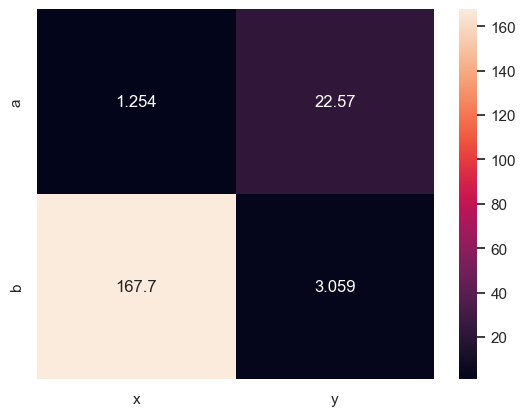

In [112]:
sns.heatmap(
    means.select(pl.col("x", "y")).to_numpy(),
    annot=True,
    fmt=".4g",
    xticklabels=["x", "y"],
    yticklabels=["a", "b"],
)

In [190]:
X = data.to_dummies(["row", "col"]).select(pl.all().exclude("samples"))
y = data["samples"]

model = Ridge(alpha=1e-10)
model.fit(X, y)

Ridge(alpha=1e-10)

In [191]:
print(f"Model Intercept: {model.intercept_:.4g}")
print(f"Total Sample Mean: {data['samples'].mean():.4g}")

Model Intercept: 48.37
Total Sample Mean: 48.64


In [192]:
coef_lookup = dict(zip(X.columns, model.coef_))
coef_lookup

{'row_a': -36.78884262904634,
 'row_b': 36.65454545454546,
 'col_x': 36.14744491687776,
 'col_y': -35.4909090909091}

In [193]:
row_a_mean = data.filter(pl.col("row") == "a")["samples"].mean()
model_row_a_mean = model.intercept_ + coef_lookup["row_a"]

print(f"Row a Sample Mean: {row_a_mean:.4g}")
print(f"Model Row a Prediction: {model_row_a_mean:.4g}")

Row a Sample Mean: 11.91
Model Row a Sample Mean: 11.59


In [194]:
a_x_mean = data.filter(pl.col("row") == "a", pl.col("col") == "x")["samples"].mean()
model_a_x_mean = model.intercept_ + coef_lookup["row_a"] + coef_lookup["col_x"]

print(f"Row a Column x Sample Mean: {a_x_mean:.4g}")
print(f"Model Row a Column x Prediction: {model_a_x_mean:.4g}")

Row a Column x Sample Mean: 1.254
Model Row a Column x Sample Mean: 47.73


In [197]:
rows = ["a", "b"]
cols = ["x", "y"]

for row in rows:
    for col in cols:
        X = X.with_columns(
            (pl.col(f"row_{row}") * pl.col(f"col_{col}")).alias(f"{row}_{col}")
        )

model = Ridge(alpha=1e-10)
model.fit(X, y)

Ridge(alpha=1e-10)

In [198]:
print(f"Model Intercept: {model.intercept_:.4g}")
print(f"Total Sample Mean: {data['samples'].mean():.4g}")

Model Intercept: 50.57
Total Sample Mean: 48.64


In [199]:
coef_lookup = dict(zip(X.columns, model.coef_))
coef_lookup

{'row_a': -8.24072171620896,
 'row_b': 8.106424541707781,
 'col_x': 35.33776358836358,
 'col_y': -34.68122776239491,
 'a_x': -76.40953126365213,
 'a_y': 14.93050227902428,
 'b_x': 73.646106761728,
 'b_y': -20.93265209500514}

In [204]:
row_a_mean = data.filter(pl.col("row") == "a")["samples"].mean()
model_row_a_mean = model.intercept_ + coef_lookup["row_a"]

print(f"Row a Sample Mean: {row_a_mean:.4g}")
print(f"Model Row a Prediction: {model_row_a_mean:.4g}")

Row a Sample Mean: 11.91
Model Row a Sample Mean: 42.33


In [205]:
a_x_mean = data.filter(pl.col("row") == "a", pl.col("col") == "x")["samples"].mean()
model_a_x_mean = (
    model.intercept_ + coef_lookup["row_a"] + coef_lookup["col_x"] + coef_lookup["a_x"]
)

print(f"Row a Column x Sample Mean: {a_x_mean:.4g}")
print(f"Model Row a Column x Prediction: {model_a_x_mean:.4g}")

Row a Column x Sample Mean: 1.254
Model Row a Column x Sample Mean: 1.254


# Log-Link Model

In [216]:
X = data.to_dummies(["row", "col"]).select(pl.all().exclude("samples"))
y = data["samples"].log()

model = Ridge(alpha=1e-10)
model.fit(X, y)

Ridge(alpha=1e-10)

In [234]:
print(f"Model Intercept: {model.intercept_:.4g}")
print(f"Total Sample Mean: {data['samples'].log().mean():.4g}")

Model Intercept: 2.272
Total Sample Mean: 2.271


In [240]:
print(f"Model Intercept: {np.exp(model.intercept_):.4g}")
print(f"Total Sample Mean: {data['samples'].mean():.4g}")

Model Intercept: 9.699
Total Sample Mean: 48.64


In [218]:
coef_lookup = dict(zip(X.columns, model.coef_))
coef_lookup

{'row_a': -0.723482270762994,
 'row_b': 0.7272727272727274,
 'col_x': 0.2765203403144304,
 'col_y': -0.28181818181818186}

In [239]:
row_a_mean = data.filter(pl.col("row") == "a")["samples"].log().mean()
model_row_a_mean = model.intercept_ + coef_lookup["row_a"]

print(f"Row a Sample Mean: {row_a_mean:.4g}")
print(f"Model Row a Prediction: {model_row_a_mean:.4g}")

Row a Sample Mean: 1.546
Model Row a Prediction: 1.549


In [238]:
row_a_mean = data.filter(pl.col("row") == "a")["samples"].mean()
model_row_a_mean = np.exp(model.intercept_ + coef_lookup["row_a"])

print(f"Row a Sample Mean: {row_a_mean:.4g}")
print(f"Model Row a Prediction: {model_row_a_mean:.4g}")

Row a Sample Mean: 11.91
Model Row a Prediction: 4.705


In [236]:
a_x_mean = (
    data.filter(pl.col("row") == "a", pl.col("col") == "x")["samples"].log().mean()
)
model_a_x_mean = model.intercept_ + coef_lookup["row_a"] + coef_lookup["col_x"]

print(f"Row a Column x Sample Mean: {a_x_mean:.4g}")
print(f"Model Row a Column x Prediction: {model_a_x_mean:.4g}")

Row a Column x Sample Mean: 0.1009
Model Row a Column x Prediction: 1.825


# GLM

In [262]:
X = data.to_dummies(["row", "col"]).select(pl.all().exclude("samples"))
y = data["samples"]

model = GammaRegressor(alpha=1e-10)
model.fit(X, y)

GammaRegressor(alpha=1e-10)

In [263]:
print(f"Model Intercept: {model.intercept_:.4g}")
print(f"Total Sample Mean: {data['samples'].log().mean():.4g}")

Model Intercept: 3.671
Total Sample Mean: 2.271


In [264]:
print(f"Model Intercept: {np.exp(model.intercept_):.4g}")
print(f"Total Sample Mean: {data['samples'].mean():.4g}")

Model Intercept: 39.29
Total Sample Mean: 48.64


In [266]:
coef_lookup = dict(zip(X.columns, model.coef_))
coef_lookup

{'row_a': -0.8310197119171716,
 'row_b': 0.6176217597500379,
 'col_x': 0.1715292110805544,
 'col_y': -0.3849271632477188}

In [267]:
row_a_mean = data.filter(pl.col("row") == "a")["samples"].log().mean()
model_row_a_mean = model.intercept_ + coef_lookup["row_a"]

print(f"Row a Sample Mean: {row_a_mean:.4g}")
print(f"Model Row a Prediction: {model_row_a_mean:.4g}")

Row a Sample Mean: 1.546
Model Row a Prediction: 2.84


In [268]:
row_a_mean = data.filter(pl.col("row") == "a")["samples"].mean()
model_row_a_mean = np.exp(model.intercept_ + coef_lookup["row_a"])

print(f"Row a Sample Mean: {row_a_mean:.4g}")
print(f"Model Row a Prediction: {model_row_a_mean:.4g}")

Row a Sample Mean: 11.91
Model Row a Prediction: 17.11


In [269]:
a_x_mean = (
    data.filter(pl.col("row") == "a", pl.col("col") == "x")["samples"].log().mean()
)
model_a_x_mean = model.intercept_ + coef_lookup["row_a"] + coef_lookup["col_x"]

print(f"Row a Column x Sample Mean: {a_x_mean:.4g}")
print(f"Model Row a Column x Prediction: {model_a_x_mean:.4g}")

Row a Column x Sample Mean: 0.1009
Model Row a Column x Prediction: 3.011


In [270]:
a_x_mean = data.filter(pl.col("row") == "a", pl.col("col") == "x")["samples"].mean()
model_a_x_mean = np.exp(model.intercept_ + coef_lookup["row_a"] + coef_lookup["col_x"])

print(f"Row a Column x Sample Mean: {a_x_mean:.4g}")
print(f"Model Row a Column x Prediction: {model_a_x_mean:.4g}")

Row a Column x Sample Mean: 1.254
Model Row a Column x Prediction: 20.32


<Axes: ylabel='Count'>

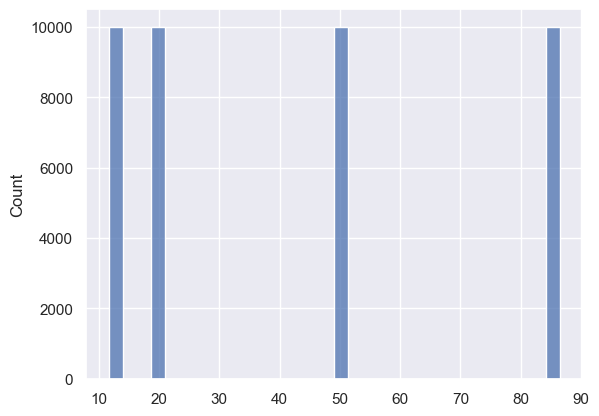

In [275]:
sns.histplot(model.predict(X))